# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2023/07/10<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

## Introduction of the EfficientNet

EfficientNet, introdotto per la prima volta in Tan e Le, 2019, è tra i modelli più efficienti (ovvero che richiedono il minor numero di FLOPS per l'inferenza) e raggiunge un'accuratezza allo stato dell'arte sia nelle attività di imagenet che in quelle di transfer learning per la classificazione di immagini.

Il modello base più piccolo è simile a MnasNet, che ha raggiunto quasi il SOTA con un modello significativamente più piccolo. Introducendo un metodo euristico per scalare il modello, EfficientNet fornisce una famiglia di modelli (da B0 a B7) che rappresenta una buona combinazione di efficienza e accuratezza su diverse scale. Tale euristica di scala (compound-scaling, per maggiori dettagli vedere Tan e Le, 2019) consente al modello base orientato all'efficienza (B0) di superare i modelli a ogni scala, evitando al contempo un'estesa ricerca di iperparametri sulla griglia.

Un riepilogo degli ultimi aggiornamenti del modello è disponibile qui, dove vengono applicati vari schemi di potenziamento e approcci di apprendimento semi-supervisionato per migliorare ulteriormente le prestazioni imagenet dei modelli. Queste estensioni del modello possono essere utilizzate aggiornando i pesi senza modificare l'architettura del modello.

## B0 to B7 variants of EfficientNet

(Questa sezione fornisce alcuni dettagli sulla "scalatura composta" e può essere saltata se si è interessati solo all'utilizzo dei modelli)

Sulla base dell'articolo originale, si potrebbe avere l'impressione che EfficientNet sia una famiglia continua di modelli creati scegliendo arbitrariamente il fattore di scala come nell'Eq.(3) dell'articolo. Tuttavia, la scelta di risoluzione, profondità e larghezza è limitata anche da molti fattori:

Risoluzione: le risoluzioni non divisibili per 8, 16, ecc. causano il riempimento con zeri in prossimità dei bordi di alcuni livelli, con conseguente spreco di risorse computazionali. Questo vale soprattutto per le varianti più piccole del modello, quindi la risoluzione di input per B0 e B1 è stata scelta a 224 e
Profondità e larghezza: i componenti fondamentali di EfficientNet richiedono che le dimensioni del canale siano multipli di 8.

Limite di risorse: la limitazione di memoria può creare un collo di bottiglia nella risoluzione quando profondità e larghezza possono ancora aumentare. In tale situazione, aumentare la profondità e/o la larghezza mantenendo la risoluzione può comunque migliorare le prestazioni.

Di conseguenza, la profondità, l'ampiezza e la risoluzione di ciascuna variante dei modelli EfficientNet vengono selezionate con cura e hanno dimostrato di produrre buoni risultati, sebbene possano discostarsi significativamente dalla formula di scala composta. Pertanto, l'implementazione di Keras (descritta di seguito) fornisce solo questi 8 modelli, da B0 a B7, invece di consentire una scelta arbitraria dei parametri di ampiezza/profondità/risoluzione.



## Keras implementation of EfficientNet

Un'implementazione di EfficientNet da B0 a B7 è stata fornita con Keras a partire dalla versione 2.3. Per utilizzare EfficientNetB0 per classificare 1000 classi di immagini da ImageNet, eseguire:

```python
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')
```

Questo modello accetta immagini di input di forma `(224, 224, 3)` e i dati di input devono essere compresi nell'intervallo `[0, 255]`. La normalizzazione è inclusa come parte del modello.

Poiché l'addestramento di EfficientNet su ImageNet richiede un'enorme quantità di risorse e
diverse tecniche che non fanno parte dell'architettura del modello stesso, l'implementazione di Keras
carica di default i pesi pre-addestrati ottenuti tramite l'addestramento con
[AutoAugment](https://arxiv.org/abs/1805.09501).
For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

Quando il modello è destinato al transfer learning, l'implementazione di Keras
offre un'opzione per rimuovere i livelli superiori:

```
model = EfficientNetB0(include_top=False, weights='imagenet')
```

Questa opzione esclude il layer finale `Dense` che trasforma 1280 feature sul penultimo
layer in una previsione delle 1000 classi ImageNet. La sostituzione del layer superiore con layer personalizzati
consente di utilizzare EfficientNet come estrattore di feature in un flusso di lavoro di apprendimento basato sul trasferimento.

Un altro argomento degno di nota nel costruttore del modello è `drop_connect_rate`, che controlla
il tasso di abbandono responsabile della [profondità stocastica](https://arxiv.org/abs/1603.09382).
Questo parametro serve come interruttore per una regolarizzazione aggiuntiva durante la messa a punto, ma non
influenza i pesi caricati. Ad esempio, quando si desidera una regolarizzazione più forte, provare:

```python
model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.4)
```
The default value is 0.2.

## Example: EfficientNetB0 for Stanford Dogs.

EfficientNet è in grado di svolgere un'ampia gamma di attività di classificazione delle immagini.
Questo lo rende un buon modello per il transfer learning.
Come esempio completo, mostreremo l'utilizzo di EfficientNetB0 pre-addestrato sul
dataset [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html).

## Setup and data loading

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64


### Loading data

Here we load data from [tensorflow_datasets](https://www.tensorflow.org/datasets)
(hereafter TFDS).
Stanford Dogs dataset is provided in
TFDS as [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs).
It features 20,580 images that belong to 120 classes of dog breeds
(12,000 for training and 8,580 for testing).

By simply changing `dataset_name` below, you may also try this notebook for
other datasets in TFDS such as
[cifar10](https://www.tensorflow.org/datasets/catalog/cifar10),
[cifar100](https://www.tensorflow.org/datasets/catalog/cifar100),
[food101](https://www.tensorflow.org/datasets/catalog/food101),
etc. When the images are much smaller than the size of EfficientNet input,
we can simply upsample the input images. It has been shown in
[Tan and Le, 2019](https://arxiv.org/abs/1905.11946) that transfer learning
result is better for increased resolution even if input images remain small.

In [2]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.3DR9PM_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.3DR9PM_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

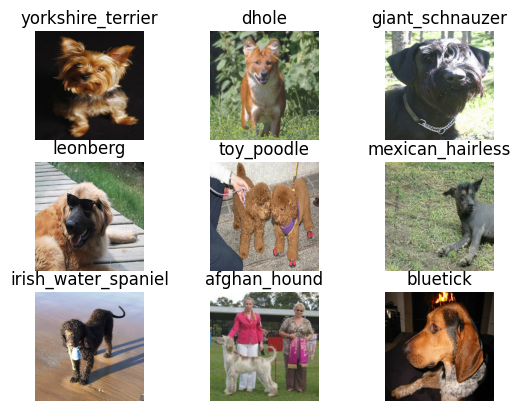

In [4]:

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [5]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


Questo oggetto modello `Sequenziale` può essere utilizzato sia come parte del
modello che costruiremo in seguito, sia come funzione per preelaborare
i dati prima di inserirli nel modello. Usarli come funzione semplifica
la visualizzazione delle immagini aumentate. Qui presentiamo 9 esempi
di risultati di aumento di una data figura.

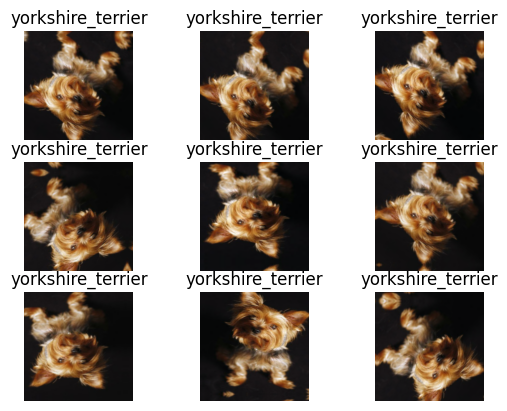

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Una volta verificato il corretto funzionamento dei dati di input e dell'aumento,
prepariamo il set di dati per l'addestramento. I dati di input vengono ridimensionati a un valore uniforme
`IMG_SIZE`. Le etichette vengono codificate in modo one-hot
(anche noto come codifica categorica). Il set di dati viene elaborato in batch.

Nota: `prefetch` e `AUTOTUNE` possono in alcune situazioni migliorare
le prestazioni, ma ciò dipende dall'ambiente e dal set di dati specifico utilizzato.
Consultare questa [guida](https://www.tensorflow.org/guide/data_performance)
per ulteriori informazioni sulle prestazioni della pipeline dati.


In [7]:

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


## Training a model from scratch

We build an EfficientNetB0 with 120 output classes, that is initialized from scratch:

Note: the accuracy will increase very slowly and may overfit.

In [8]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.0095 - loss: 5.0819 - val_accuracy: 0.0105 - val_loss: 4.9506
Epoch 2/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.0178 - loss: 4.7239 - val_accuracy: 0.0177 - val_loss: 4.9142
Epoch 3/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.0293 - loss: 4.5109 - val_accuracy: 0.0306 - val_loss: 4.4685
Epoch 4/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.0374 - loss: 4.3619 - val_accuracy: 0.0431 - val_loss: 4.4343
Epoch 5/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.0487 - loss: 4.2429 - val_accuracy: 0.0455 - val_loss: 4.3161
Epoch 6/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.0561 - loss: 4.1480 - val_accuracy: 0.0338 - val_loss: 5.2584
Epoch 7/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.0701 - loss: 4.0734 - val_accuracy: 0.0496 - val_loss: 4.3442
Epoch 8/40
187/187 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.0786 - loss: 3.9852 - val_accu

L'addestramento del modello è relativamente rapido. Questo potrebbe far sembrare semplice addestrare EfficientNet su qualsiasi
dataset desiderato partendo da zero. Tuttavia, addestrare EfficientNet su dataset più piccoli,
specialmente quelli con risoluzione inferiore come CIFAR-100, si scontra con la significativa sfida del
sovraadattamento.

Pertanto, l'addestramento da zero richiede una scelta molto accurata degli iperparametri ed è
difficile trovare una regolarizzazione adeguata. Sarebbe anche molto più impegnativo in termini di risorse.
Graficando l'accuratezza dell'addestramento e della convalida
si evince chiaramente che l'accuratezza della convalida si attesta su un valore basso.

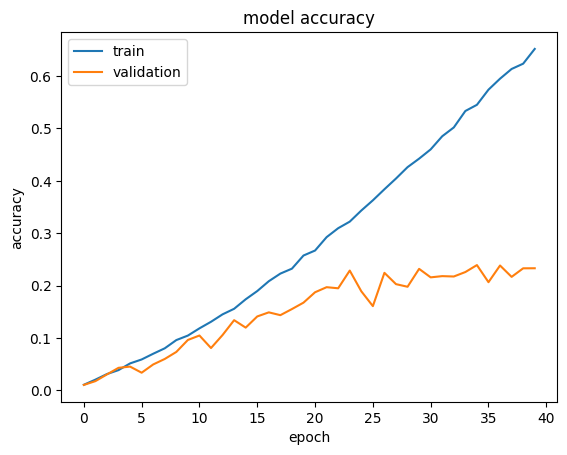

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

## Transfer learning from pre-trained weights

Qui inizializziamo il modello con pesi ImageNet pre-addestrati e lo perfezioniamo sul nostro set di dati.


In [10]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Il primo passo per il transfer learning è congelare tutti i livelli e addestrare solo i livelli superiori. Per questa fase, è possibile utilizzare un tasso di apprendimento relativamente elevato (1e-2).
Si noti che l'accuratezza e la perdita di convalida saranno solitamente migliori dell'accuratezza e della perdita di addestramento.
Questo perché la regolarizzazione è forte, il che sopprime solo
le metriche relative al tempo di addestramento.

Si noti che la convergenza può richiedere fino a 50 epoche, a seconda del tasso di apprendimento scelto.
Se non fossero applicati livelli di aumento delle immagini, l'accuratezza di convalida potrebbe raggiungere solo circa il 60%.

In [11]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 195s 930ms/step - accuracy: 0.3339 - loss: 3.8627 - val_accuracy: 0.7329 - val_loss: 0.8888
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 177s 949ms/step - accuracy: 0.5794 - loss: 1.7048 - val_accuracy: 0.7856 - val_loss: 0.6978
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 173s 924ms/step - accuracy: 0.6253 - loss: 1.3220 - val_accuracy: 0.7975 - val_loss: 0.6845
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 172s 920ms/step - accuracy: 0.6495 - loss: 1.2124 - val_accuracy: 0.7907 - val_loss: 0.6885
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 179s 959ms/step - accuracy: 0.6606 - loss: 1.1844 - val_accuracy: 0.7942 - val_loss: 0.6792
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 171s 914ms/step - accuracy: 0.6786 - loss: 1.1187 - val_accuracy: 0.7830 - val_loss: 0.7283
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 173s 925ms/step - accuracy: 0.6711 - loss: 1.1023 - val_accuracy: 0.7822 - val_loss: 0.7490
Epoch 8/25
187/187 ━━━━━━

KeyboardInterrupt: 

Il secondo passaggio consiste nello scongelare un certo numero di livelli e adattare il modello utilizzando un tasso di apprendimento inferiore. In questo esempio mostriamo lo scongelamento di tutti i livelli, ma a seconda del dataset specifico, potrebbe essere opportuno scongelare solo una frazione di tutti i livelli.

Quando l'estrazione di feature con un modello pre-addestrato funziona sufficientemente bene, questo passaggio fornirebbe un guadagno molto limitato in termini di
accuratezza della convalida. Nel nostro caso osserviamo solo un piccolo miglioramento, poiché il pre-addestramento di ImageNet ha già esposto il modello a un buon numero di cani.

D'altra parte, quando utilizziamo pesi pre-addestrati su un dataset più diverso da ImageNet, questo passaggio di ottimizzazione può essere cruciale, poiché anche l'estrattore di feature deve essere modificato in modo considerevole. Tale situazione può essere dimostrata scegliendo invece il dataset CIFAR-100, dove l'ottimizzazione aumenta l'accuratezza della convalida di circa il 10%, raggiungendo l'80% su `EfficientNetB0`.

Una nota a margine sul congelamento/scongelamento dei modelli: impostando `trainable` di un `Model`,
tutti i livelli appartenenti al `Model` verranno impostati simultaneamente sullo stesso attributo `trainable`.
Ogni livello è addestrabile solo se sia il livello stesso sia il modello
che lo contiene sono addestrabili. Pertanto, quando dobbiamo congelare/scongelare parzialmente
un modello, dobbiamo assicurarci che l'attributo `trainable` del modello sia impostato
su `True`.


In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

### Tips for fine tuning EfficientNet


Per quanto riguarda lo scongelamento dei livelli:

- I livelli `BatchNormalization` devono essere mantenuti congelati
([maggiori dettagli](https://keras.io/guides/transfer_learning/)).
Se vengono impostati anche su addestrabili, la
prima epoca dopo lo scongelamento ridurrà significativamente la precisione.
- In alcuni casi potrebbe essere utile aprire solo una parte dei livelli invece di
scongelarli tutti. Questo renderà la messa a punto molto più rapida quando si passa a modelli più grandi come
B7.
- Ogni blocco deve essere attivato o disattivato completamente. Questo perché l'architettura include
una scorciatoia dal primo all'ultimo livello per ogni blocco. Il mancato rispetto dei blocchi
danneggia significativamente anche le prestazioni finali.

Altri suggerimenti per l'utilizzo di EfficientNet:

- Le varianti più grandi di EfficientNet non garantiscono prestazioni migliori, soprattutto per
attività con meno dati o meno classi. In tal caso, più grande è la variante di EfficientNet
scelta, più difficile sarà la messa a punto degli iperparametri. - EMA (Media Mobile Esponenziale) è molto utile per addestrare EfficientNet da zero,
ma non altrettanto per il transfer learning.
- Non utilizzare la configurazione RMSprop come nel documento originale per il transfer learning. Il
momentum e il tasso di apprendimento sono troppo elevati per il transfer learning. Corromperebbero facilmente il
peso pre-addestrato e farebbero aumentare la perdita. Un rapido controllo consiste nel verificare se la perdita (come entropia incrociata categoriale) sta diventando significativamente maggiore di log(NUM_CLASSES) dopo la stessa
epoca. In tal caso, il tasso/momentum di apprendimento iniziale è troppo elevato.
- Una dimensione del batch più piccola migliora l'accuratezza della convalida, probabilmente grazie all'efficace regolarizzazione.